In [121]:
# Imports
import pandas as pd
import numpy as np
import os

In [122]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [123]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [124]:
df.head(10)

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment,words_str
0,1532325760148590593,@xbresson British Alps :-),replied_to,62044012,False,0,0,1,2,33022,3383,5246,359,"['british', 'alps']",0.0000,neutral,british alps
1,1312410689059913731,RT @Aistats2020: Videos presentations of paper...,retweeted,1290762290224984064,False,52,0,0,0,17570,541,703,222,"['videos', 'presentations', 'papers', 'keynote...",0.0000,neutral,videos presentations papers keynote talks aist...
2,1564467011781926913,I hope I would be able to talk more about this...,quoted,3363584909,False,1,0,0,3,65506,113,15406,856,"['hope', 'would', 'able', 'talk', 'balcony', '...",0.4862,neutral,hope would able talk balcony tomorrow pm et al...
3,1473395733344788481,RT @dlbcnai: Keynote by Joan Bruna (@joanbruna...,retweeted,1071640880,False,35,0,0,0,21847,555,1346,264,"['keynote', 'joan', 'bruna', 'geometric', 'dee...",0.3612,neutral,keynote joan bruna geometric deep learning pro...
4,1611495430843502593,@annargrs @Michael_J_Black @AllenHW0 @CSProfKG...,replied_to,48008938,False,0,0,1,5,427851,582,12949,6488,"['process', 'science', 'relies', 'much', 'basi...",-0.3182,neutral,process science relies much basic honesty part...
5,1228672069333848064,RT @geoffreyhinton: Unsupervised learning of r...,retweeted,1071640880,False,519,0,0,0,21847,555,1346,264,"['unsupervised', 'learning', 'representations'...",0.3384,neutral,unsupervised learning representations beginnin...
6,1595340090963857410,"@prem_k Relax, it's a joke!",replied_to,48008938,False,0,0,2,2,427851,582,12949,6488,"['relax', 'joke']",0.6249,positive,relax joke
7,1585623984858869765,Postdoctoral position available in Computation...,tweet,62044012,False,18,1,0,68,33022,3383,5246,359,"['postdoctoral', 'position', 'available', 'com...",0.4404,neutral,postdoctoral position available computational ...
8,1529505378911891457,@textfiles I did note the irony of being somew...,replied_to,175624200,False,0,0,2,20,1031629,225,16316,6967,"['note', 'irony', 'somewhat', 'phone', 'phreak...",-0.3969,neutral,note irony somewhat phone phreak ham radio spa...
9,1624987333522239489,@repligate @reality__gamer are you sure it nev...,replied_to,232294292,False,0,0,2,0,86646,5312,26291,2422,"['sure', 'never', 'made', 'illegal', 'moves', ...",0.4449,positive,sure never made illegal moves add additional c...


In [125]:
from sentence_transformers import SentenceTransformer

# Specify the model name
# I downloaded in models directory three models: 
# all-MiniLM-L6-v2(Fastest but smalles), stsb-roberta-base-v2(middle), and stsb-mpnet-base-v2(Slowest, but best performance)

name = 'stsb-mpnet-base-v2'


# Download and save the model if not available
#model = SentenceTransformer(name)

#model.save('models/' + name)

# Load the model
model_enc = SentenceTransformer('models/' + name).to('cuda')

In [126]:
# Augmentation
from random import shuffle
import nltk
from nltk.corpus import wordnet

# Download WordNet data
nltk.download('wordnet')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = np.random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [127]:
# Original data
original_sentences = list(df.words_str.values)

# Augmented data
augmented_sentences = original_sentences.copy()
for _ in range(4): # 4 times to make the total data 5 times
    augmented_sentences += [synonym_replacement(sentence) for sentence in original_sentences]

# Use augmented sentences for embeddings
sentences = augmented_sentences
sentence_embeddings = model_enc.encode(sentences)
X = sentence_embeddings

# Original target
original_y = df.score_compound.values

# Augmented target
y = np.tile(original_y, 5) # Repeat 5 times


In [128]:
# # List of sentences to get embeddings for
# sentences = list(df.words_str.values)

# # Get the sentence embeddings
# sentence_embeddings = model_enc.encode(sentences)

# Regression

In [129]:
# X = sentence_embeddings
# y = df.score_compound.values

In [130]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

In [131]:
#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

In [132]:
# # Split data into training and validation sets
# df_train, df_val = train_test_split(df, test_size=0.4, random_state=42)

# # Original training sentences
# original_sentences_train = list(df_train.words_str.values)

# # Augmented training sentences
# augmented_sentences_train = original_sentences_train.copy()
# for _ in range(4): # 4 times to make the total training data 5 times
#     augmented_sentences_train += [synonym_replacement(sentence) for sentence in original_sentences_train]

# # Use augmented training sentences for embeddings
# sentence_embeddings_train = model_enc.encode(augmented_sentences_train)
# X_train = sentence_embeddings_train

# # Repeat the training target variable 5 times
# y_train = np.tile(df_train.score_compound.values, 5)

# # Validation data remains unchanged
# X_val = model_enc.encode(list(df_val.words_str.values))
# y_val = df_val.score_compound.values

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(RegressionNN, self).__init__()
        
        # First set of layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Second set of layers
        self.fc3 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        # First set of layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # Second set of layers
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        # Output
        x = self.fc5(x)
        return x


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [135]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)


In [136]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.001
epochs = 500
batch_size = 32

# Initialize the model and move to the device
model_reg = RegressionNN(X_train.shape[1]).to(device)

# Loss and optimizer
criterion = nn.HuberLoss().to(device)
weight_decay_value = 1e-5  # This is a hyperparameter and can be adjusted
optimizer = torch.optim.AdamW(model_reg.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

# Helper function to compute RMSE
def compute_rmse(y_true, y_pred):
    mse_loss = torch.nn.MSELoss()
    mse = mse_loss(y_true, y_pred)
    return torch.sqrt(mse)

# Training loop
training_losses = []
validation_losses = []
training_rmse = []
validation_rmse = []

best_rmse = float('inf')  # start with a very high value
best_epoch = -1  # an invalid epoch number to start with

for epoch in range(epochs):
    # Set model to training mode and ensure it's on the right device
    model_reg.train().to(device)
    
    # Forward pass on training data
    train_outputs = model_reg(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Set model to evaluation mode
    model_reg.eval()
    with torch.no_grad():
        # Forward pass on validation data
        val_outputs = model_reg(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        scheduler.step(val_loss)
    
    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())
    
    # Calculate and store the RMSE for plotting
    train_rmse = compute_rmse(y_train_tensor, train_outputs)
    val_rmse = compute_rmse(y_val_tensor, val_outputs)
    training_rmse.append(train_rmse.item())
    validation_rmse.append(val_rmse.item())
    
    current_val_rmse = val_rmse.item()

    # Check if the current RMSE is better than the best RMSE
    if current_val_rmse < best_rmse:
        best_rmse = current_val_rmse
        best_epoch = epoch
    else:
        # Stop training after a certain number of epochs without improvement
        if epoch - best_epoch > 10000:
            print(f"Stopping training after {epoch} epochs. Best RMSE {best_rmse:.4f} achieved at epoch {best_epoch}.")
            break
    
    # Print progress
    if epoch < 100 and epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse.item():.4f}, Validation RMSE: {val_rmse.item():.4f}')
    elif 100 < epoch < 300 and epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse.item():.4f}, Validation RMSE: {val_rmse.item():.4f}')
    elif 300 < epoch < 1000 and epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse.item():.4f}, Validation RMSE: {val_rmse.item():.4f}')
    elif epoch > 1000 and epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse.item():.4f}, Validation RMSE: {val_rmse.item():.4f}')

# If the loop completed without breaking, print the best RMSE achieved
if best_epoch != epoch:
    print(f"Training completed. Best RMSE {best_rmse:.4f} achieved at epoch {best_epoch}.")

Epoch [1/500], Training Loss: 0.1394, Validation Loss: 0.1307, Training RMSE: 0.5280, Validation RMSE: 0.5112
Epoch [6/500], Training Loss: 0.1042, Validation Loss: 0.0951, Training RMSE: 0.4566, Validation RMSE: 0.4362
Epoch [11/500], Training Loss: 0.0919, Validation Loss: 0.0833, Training RMSE: 0.4289, Validation RMSE: 0.4081
Epoch [16/500], Training Loss: 0.0847, Validation Loss: 0.0806, Training RMSE: 0.4116, Validation RMSE: 0.4015
Epoch [21/500], Training Loss: 0.0812, Validation Loss: 0.0728, Training RMSE: 0.4033, Validation RMSE: 0.3816
Epoch [26/500], Training Loss: 0.0777, Validation Loss: 0.0745, Training RMSE: 0.3942, Validation RMSE: 0.3861
Epoch [31/500], Training Loss: 0.0748, Validation Loss: 0.0688, Training RMSE: 0.3869, Validation RMSE: 0.3710
Epoch [36/500], Training Loss: 0.0724, Validation Loss: 0.0697, Training RMSE: 0.3806, Validation RMSE: 0.3735
Epoch [41/500], Training Loss: 0.0702, Validation Loss: 0.0651, Training RMSE: 0.3748, Validation RMSE: 0.3610
Epo

Epoch [91/500], Training Loss: 0.0454, Validation Loss: 0.0419, Training RMSE: 0.3015, Validation RMSE: 0.2895
Epoch [96/500], Training Loss: 0.0424, Validation Loss: 0.0390, Training RMSE: 0.2914, Validation RMSE: 0.2794
Epoch [111/500], Training Loss: 0.0347, Validation Loss: 0.0316, Training RMSE: 0.2633, Validation RMSE: 0.2517
Epoch [121/500], Training Loss: 0.0309, Validation Loss: 0.0276, Training RMSE: 0.2487, Validation RMSE: 0.2350
Epoch [131/500], Training Loss: 0.0277, Validation Loss: 0.0247, Training RMSE: 0.2354, Validation RMSE: 0.2226
Epoch [141/500], Training Loss: 0.0249, Validation Loss: 0.0229, Training RMSE: 0.2233, Validation RMSE: 0.2143
Epoch [151/500], Training Loss: 0.0229, Validation Loss: 0.0213, Training RMSE: 0.2140, Validation RMSE: 0.2064
Epoch [161/500], Training Loss: 0.0214, Validation Loss: 0.0204, Training RMSE: 0.2067, Validation RMSE: 0.2024
Epoch [171/500], Training Loss: 0.0202, Validation Loss: 0.0192, Training RMSE: 0.2012, Validation RMSE: 0

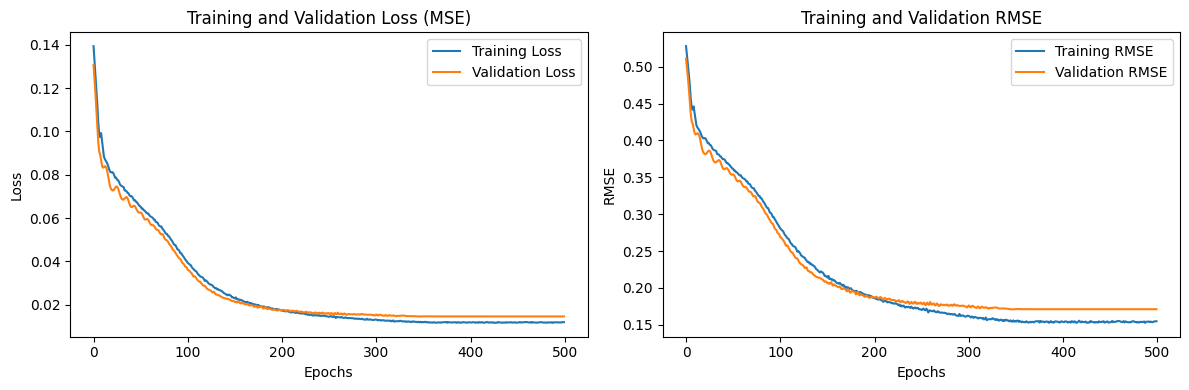

In [137]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(training_rmse, label='Training RMSE')
plt.plot(validation_rmse, label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [138]:
# Encode the test sentences
sentences = list(df_test.words_str.values)
X_test = model_enc.encode(sentences)

# Convert to a PyTorch tensor and move to the device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predictions with the neural network
model_reg.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_hat_tensor = model_reg(X_test_tensor)

# Convert the predictions back to a numpy array
y_hat = y_hat_tensor.cpu().numpy()

# Save the results with the specified format
directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), y_hat)


In [139]:
# Load 20__test_1__reg_pred.npy

np.load('results/20__test_1__reg_pred.npy', allow_pickle=True)

array([[-3.41474339e-02],
       [-2.57087667e-02],
       [ 3.86861891e-01],
       [ 5.97715735e-01],
       [-6.28891662e-02],
       [ 6.71252668e-01],
       [ 5.42409539e-01],
       [ 6.83143079e-01],
       [ 7.23325491e-01],
       [ 1.18465655e-01],
       [ 5.48119247e-01],
       [-4.32247251e-01],
       [ 7.00045526e-01],
       [-2.31637452e-02],
       [ 5.21023571e-01],
       [ 1.63782109e-02],
       [ 4.27125275e-01],
       [-4.72242385e-03],
       [ 3.22722286e-01],
       [ 6.78369641e-01],
       [ 4.53302175e-01],
       [ 5.68083763e-01],
       [ 1.11596445e-02],
       [ 3.62702817e-01],
       [ 5.56100667e-01],
       [-8.44139047e-03],
       [ 2.06264928e-01],
       [-2.69508928e-01],
       [-2.42191046e-01],
       [ 1.11055002e-03],
       [ 7.40790844e-01],
       [ 5.97930431e-01],
       [ 6.43710140e-03],
       [-2.61637699e-02],
       [ 4.40420955e-02],
       [-7.19054490e-02],
       [-8.28543864e-03],
       [ 2.69649960e-02],
       [ 3.9